In [1]:
import os
os.chdir("..")

In [2]:
from configs.parser import Parser

C = Parser("configs/default.yaml").C
C

apex:
  opt: O0
data:
  dataset:
    mode: fine
    root: ./cityscapes
    target_type: semantic
  loader:
    batch_size: 2
    num_workers: 8
  name: cityscapes
net:
  deeplab:
    head_in_ch: 2048
    num_classes: 19
    pretrained: false
    resnet: res101
  pointhead:
    beta: 0.75
    in_c: 531
    k: 3
    num_classes: 19
run:
  epochs: 200
train:
  lr: 0.01
  momentum: 0.9
  weight_decay: 0.0001

In [3]:
from datas import get_loader

train_loader = get_loader(C.data, "train", distributed=False)
valid_loader = get_loader(C.data, "val", distributed=False)

cityscapes {'root': './cityscapes', 'mode': 'fine', 'target_type': 'semantic'} train
cityscapes {'root': './cityscapes', 'mode': 'fine', 'target_type': 'semantic'} val


In [51]:
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np

to_pil = transforms.ToPILImage()


def plot(img, mask):
    img = to_pil(img).convert("RGB")
    img.save('img.png')
    to_pil(mask).convert('RGB').save('m.png')
    mask = mask.numpy()[0]
    mask[mask == 255] = 0
    print(mask)
    
    fig, ax  = plt.subplots(1, 2)
    ax[0].set_title("Image")
    ax[0].imshow(img)
    ax[1].set_title(f"Mask : {np.unique(mask)}")
    ax[1].imshow(mask)
    plt.show()

Dataset Cityscapes
    Number of datapoints: 2975
    Root location: ./cityscapes
    Split: train
    Mode: gtFine
    Type: ['semantic']
torch.Size([3, 768, 768]) torch.Size([1, 768, 768])
[[8 8 8 ... 2 2 2]
 [8 8 8 ... 2 2 2]
 [8 8 8 ... 2 2 2]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


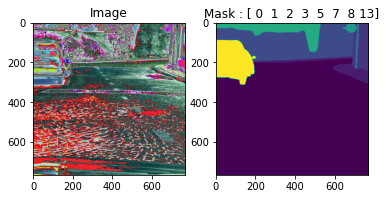

In [52]:
print(train_loader.dataset)
for img, mask in train_loader.dataset:
    print(img.shape, mask.shape)
    plot(img, mask)
    break

In [9]:
import torch
from model import deeplabv3, PointHead, PointRend
# from torchvision.models.utils import load_state_dict_from_url

device = torch.device("cuda")
net = PointRend(
  deeplabv3(**C.net.deeplab),
  PointHead(**C.net.pointhead)
).to(device)
# state_dict = load_state_dict_from_url('./epoch_0190_loss_0.61630.pth', progress=True)
net.load_state_dict(torch.load('tests/epoch_0190_loss_0.61630.pth'), strict=True) #state_dict)
net.eval()
print("Done")

Done


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


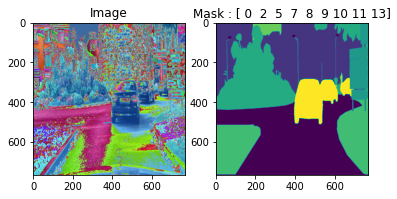

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


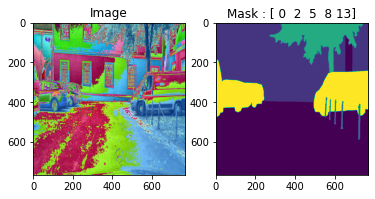

torch.Size([2, 3, 768, 768]) torch.Size([2, 1, 768, 768])
odict_keys(['res2', 'out', 'coarse', 'fine'])
(2, 19, 768, 768)


In [60]:
for i, (img, mask) in enumerate(valid_loader): #.dataset:
  plot(img[0], mask[0])
  plot(img[1], mask[1])
  print(img.shape, mask.shape)
  img = img.to(device, non_blocking=True)
  with torch.no_grad():
    # res2, out = 
    out = net(img)
    
  # res2, 
  print(out.keys())
  print(out['fine'].cpu().numpy().shape)
  break


<Figure size 432x288 with 0 Axes>

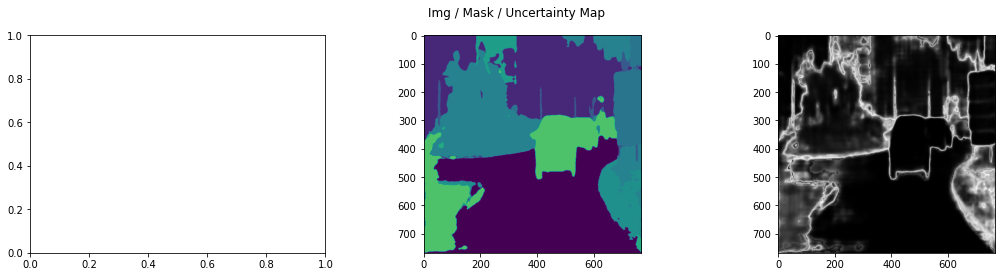

In [59]:
import matplotlib.pyplot as plt


with torch.no_grad():
    plt.figure()
    fig, ax = plt.subplots(1, 3, figsize=(18, 4))
    fig.suptitle("Img / Mask / Uncertainty Map")
    # softmax for normalize
    pred = out['fine'].softmax(1).argmax(1).float()
    # to_pil(pred[0].cpu().numpy()).convert('RGB').save('m1.png')
    # to_pil(pred[1].cpu().numpy()).convert('RGB').save('m2.png')
    """
    In Paper,
    To measure prediction uncertainty
    we use the same strategy during training and inference:
    the difference between the most confident
    and second most confident class probabilities
    """
    v, i = out['fine'].softmax(1).sort(1, descending=True)
    # uncertainty = (v[:, -1, :, :] - v[:, -2, :, :]) <= 0.5
    uncertainty = - (v[:, 0, :, :] - v[:, 1, :, :])
    
    # ax[0].imshow(input_pil)
    ax[1].imshow(pred[0].cpu().numpy())
    plt.imsave('m1.png',pred[0].cpu().numpy())
    plt.imsave('m2.png',pred[1].cpu().numpy())
    ax[2].imshow(uncertainty[0].cpu().numpy(), cmap="gray")
    plt.imsave('m3.png',uncertainty[0].cpu().numpy())
    plt.imsave('m4.png',uncertainty[1].cpu().numpy())
    plt.show()